# Case Study on Tweets from Ostrava

This notebook demonstrates how the proposed framework can be used in real world. We use tweets published from Ostrava and extract and aggregate sentiment on topics detected in these tweets.

In [1]:
import os
import re
import json

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from bertopic import BERTopic
from sklearn.metrics.pairwise import cosine_similarity
from textblob import TextBlob
from umap import UMAP

/home/milos/.cache/pypoetry/virtualenvs/dissertation-53o3-k0o-py3.11/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/milos/.cache/pypoetry/virtualenvs/dissertation-53o3-k0o-py3.11/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/h

## Data loading and preprocessing

We start by loading the dataset:

In [2]:
df = pd.read_csv('../datasets/tweets_ostrava_translated.csv', header=None)
df.columns = ['author_id', 'text_orig', 'date_published', 'likes', 'retweets', 'text_en']
df.head()

,author_id,text_orig,date_published,likes,retweets,text_en
0,2765861635,"Bohuzel budou do Tutecka letat dale, jen tank...",2023-03-17 02:58:29+00:00,4,1,"Unfortunately, they will continue to fly to T..."
1,946371211411513346,Já si mohu uložit tvé fotky? Bez svolení? To ...,2023-03-17 00:40:37+00:00,0,0,Can I save your pictures? Without permission?...
2,729345398,"Arsenal-Sporting, 3 hodiny zábavy 👌",2023-03-16 22:47:06+00:00,7,1,"Arsenal-Sporting, 3 hours of fun 👌"
3,864219563172532224,Levice si mne získala již ve velmi útlém věku. ✨,2023-03-16 21:21:56+00:00,31,2,The left won me over at a very young age. ✨
4,917807011152191494,tim jsem byla posedla kdyz mi bylo 11 let,2023-03-16 20:18:15+00:00,7,1,I was obsessed with it when I was 11 years old.


We are only interested in tweets that are not too short and do not containe a weird word `holytrainer`.

In [21]:
MIN_TEXT_LENGTH = 60
texts = []
texts_orig = []
retweets = []

for i, t in enumerate(df['text_en']):
    if len(str(t)) > 60 and 'holytrainer' not in t.lower():
        texts.append(t.lower().strip())
        texts_orig.append(df['text_orig'].iloc[i])
        retweets.append(df['retweets'].iloc[i] + 1)

texts[:5]


['unfortunately, they will continue to fly to tuteck, but they will refuel in soci.',
 'can i save your pictures? without permission? is that allowed? 😂😂 only ones you send me directly ☺️',
 "banik's box office fraud is a completely different transfer",
 "where the democrats rule, it looks that way, and it's getting worse.",
 "i'm not saying they shouldn't be paid on time. i'm saying that as long as these people are getting paid, it's wrong, they're doing black things with the benefits... without them, they'd have two choices, they'd either steal or they'd start working properly, that's up to them. that's what the police are there for, to motivate them."]

We perform some basic preprocessing: replacement of contractions and removal of unnecessary characters and of stopwords.

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')

texts_clean = texts

replacements = [
    ("it's", "it is"),
    ("#", ''),
    (r"[^\w\s]", ''),
    (r"\s+", ' '),
    ('dont', 'do not'),
    (' im', ' i am'),
    (r"^im", 'i am'),
    ('theres', 'there is'),
    ('thats', 'that is'),
    ('youre', 'you are'),
    ('doesnt', 'does not'),
    ('didnt', 'did not'),
    ('cant', 'can not'),
    ('couldnt', 'could not'),
    ('shouldnt', 'should not')
]

for replacement in replacements:
    texts_clean = [re.sub(replacement[0], replacement[1], t) for t in texts_clean]

stopwords_en = nltk.corpus.stopwords.words('english')
lemmatizer = nltk.stem.WordNetLemmatizer()

texts_lemmatized = [[lemmatizer.lemmatize(w) if w not in ['has', 'was'] else w for w in t.split()] for t in texts_clean]
texts_no_sw = [' '.join([w for w in t if w not in stopwords_en]) for t in texts_lemmatized]

[nltk_data] Downloading package stopwords to /home/milos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/milos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Topic modeling

I first define a custom `BERTopic` class that fixes the issue with setting custom initial topics described in https://github.com/MaartenGr/BERTopic/issues/1421

In [5]:
class MyBERTopic(BERTopic):
    def _guided_topic_modeling(self, embeddings: np.ndarray):
        seed_topic_list = [" ".join(seed_topic) for seed_topic in self.seed_topic_list]
        seed_topic_embeddings = self._extract_embeddings(seed_topic_list, verbose=self.verbose)
        seed_topic_embeddings = np.vstack([seed_topic_embeddings, embeddings.mean(axis=0)])
        sim_matrix = cosine_similarity(embeddings, seed_topic_embeddings)
        y = [np.argmax(sim_matrix[index]) for index in range(sim_matrix.shape[0])]
        y = [val if val != len(seed_topic_list) else -1 for val in y]
        for seed_topic in range(len(seed_topic_list)):
            indices = [index for index, topic in enumerate(y) if topic == seed_topic]
            embeddings[indices] = np.average([embeddings[indices], np.tile(
                [seed_topic_embeddings[seed_topic]], (len(indices), 1))], weights=[3, 1], axis=0)
        return np.array(y), embeddings


Now I fit the topic model with a UMAP random state set to a fixed value for result replication

In [6]:

umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', low_memory=False, random_state=43)
topic_model = MyBERTopic(
    language='english', top_n_words=7, n_gram_range=(1, 3), umap_model=umap_model,
    min_topic_size=8, nr_topics=50, calculate_probabilities=True, verbose=False,
    seed_topic_list=[
        ['doctor', 'hospital', 'patient', 'healthcare'],
        ['school', 'teaching', 'university', 'education'],
        ['car', 'parking', 'road', 'traffic'],
        ['free time', 'leasure', 'recreation', 'hobbies'],
        ['social services', 'social workers', 'welfare', 'elderly care']])
topic_model.fit(texts_no_sw)


In [7]:
topics = topic_model.get_topics()
topics

{-1: [('like', 0.00644013197710603),
  ('one', 0.005601770111181369),
  ('people', 0.005497906416956946),
  ('would', 0.005100339895185268),
  ('time', 0.0047838034626021065),
  ('doe', 0.004748646238124543),
  ('get', 0.004381144269339541)],
 0: [('czech', 0.015405994269842066),
  ('ukraine', 0.012673778023071049),
  ('russian', 0.012132795966202686),
  ('putin', 0.008521289904648226),
  ('republic', 0.008165595338042776),
  ('czech republic', 0.008161656262615703),
  ('ukrainian', 0.007768858063786535)],
 1: [('babi', 0.014694322196197488),
  ('vote', 0.010349798603683492),
  ('election', 0.009664991642724148),
  ('president', 0.008616670287259877),
  ('people', 0.00855078971498568),
  ('communist', 0.008532674574765491),
  ('party', 0.008186387286607552)],
 2: [('doctor', 0.016995930483287743),
  ('hospital', 0.00980239723994038),
  ('life', 0.00874033125351903),
  ('patient', 0.008654917680254722),
  ('one', 0.008407782511007496),
  ('time', 0.008130975204819172),
  ('year', 0.0074

Next we determine the overall representation of each topic in the dataset:

In [8]:
if -1 in topics:
    del topics[-1]

topic_reprs = topic_model.probabilities_.sum(axis=0)
topic_reprs = {r[0]: r[1] for r in zip(topic_model.get_topics().keys(), topic_reprs)}
topic_reprs


{0: 825.73403675695,
 1: 791.1274735654187,
 2: 439.0590113280326,
 3: 457.75007015268335,
 4: 387.29489448002516,
 5: 280.8805324009329,
 6: 267.3646931758596,
 7: 155.2023900782518,
 8: 165.085038195274,
 9: 139.07123128577973,
 10: 301.5768327719948,
 11: 235.50612667306677,
 12: 161.79059282216298,
 13: 185.61264678753815,
 14: 196.88838652780953,
 15: 84.53868342995135,
 16: 167.57173149865898,
 17: 167.85341990550495,
 18: 108.41004255618422,
 19: 112.58325768362157,
 20: 29.174066672474154,
 21: 91.62312337317294,
 22: 106.71448004481155,
 23: 114.07516203483048,
 24: 88.61463911270107,
 25: 55.99666474972223,
 26: 108.66690810715404,
 27: 52.821836362044934,
 28: 83.72482810586264,
 29: 51.78478035548486,
 30: 49.983709987752,
 31: 28.666372121521157,
 32: 28.60925208978553,
 33: 27.01787633991848,
 34: 27.49138788597013,
 35: 23.587522186807252,
 36: 25.482353332215443,
 37: 28.07327236232285,
 38: 25.400802748169532,
 39: 26.269491601038688,
 40: 26.958902517327513,
 41: 25.9

## Sentiment analysis

When determining polarities we will also deploy a simple masking to ignore tweets whose polarity is very close to 0.

In [9]:
sentiments = []
mask = []
sentiments_discrete = []

for t in texts:
    if 'holytrainer' in t.lower():
        continue
    polarity = TextBlob(t).sentiment.polarity
    sentiments.append(polarity)
    sentiments_discrete.append(1 if polarity > 0 else -1)
    if abs(polarity) < 0.05:
        mask.append([0] * 49)
    else:
        mask.append([1] * 49)

sentiments = np.array(sentiments).reshape(-1, 1)
sentiments_discrete = np.array(sentiments_discrete).reshape(-1, 1)

Next we calculate mean sentiment for each topic

In [23]:
probas_masked = topic_model.probabilities_ * np.multiply(np.array(mask), np.array(retweets)[:, np.newaxis])
print(probas_masked.shape)
mean_sentiments = (sentiments * probas_masked).sum(axis=0) / probas_masked.sum(axis=0)
mean_sentiments_discrete = (sentiments_discrete * probas_masked).sum(axis=0) / probas_masked.sum(axis=0)
diversity_discrete = (((((sentiments_discrete - mean_sentiments_discrete) ** 2) * probas_masked).sum(axis=0)) / \
                      probas_masked.sum(axis=0))

positive_opinions = np.clip((sentiments_discrete * probas_masked), a_min=0, a_max=np.inf).sum(axis=0)
negative_opinions = - np.clip((sentiments_discrete * probas_masked), a_min=-np.inf, a_max=0).sum(axis=0)

total = negative_opinions + positive_opinions
positive_opinions = positive_opinions / total
negative_opinions = negative_opinions / total

entropy = - positive_opinions * np.log2(positive_opinions) - negative_opinions * np.log2(negative_opinions)

(9766, 49)


Then we determine the semivariance for both sides:

In [24]:
def semivariance(data, mean: np.ndarray, probas: np.ndarray, side):
    semivariances = []
    for i in range(len(mean)):
        if side == 'left':
            semi_data = data[data < mean[i]]
            semi_probas = probas[(data < mean[i]).reshape(-1), i]
        else:
            semi_data = data[data > mean[i]]
            semi_probas = probas[(data > mean[i]).reshape(-1), i]
        nominator = (((semi_data - mean[i]) ** 2) * semi_probas).sum(axis=0)
        denominator = semi_probas.sum(axis=0)
        result = np.sqrt(nominator / denominator)
        semivariances.append(result)
    return semivariances


semivariance_left = semivariance(sentiments, mean_sentiments, probas_masked, 'left')
semivariance_right = semivariance(sentiments, mean_sentiments, probas_masked, 'right')

semivariance_left[:5], semivariance_right[:5]

([0.405534675378273,
  0.3682149535287224,
  0.3773740737561939,
  0.3406574736254931,
  0.40672759259012176],
 [0.3081305084140804,
  0.279279098640579,
  0.2796180456019926,
  0.27377730714444226,
  0.30361830274546275])

# Conformity calculation

In [12]:
def conformity_positive(answer_fuzzy, neg_a, neg_b):
    if answer_fuzzy[1] >= neg_b:
        possibility = 1
    elif answer_fuzzy[2] <= neg_a:
        possibility = 0
    else:
        x = (neg_a * answer_fuzzy[1] - answer_fuzzy[2] * neg_b) / \
            (neg_a - neg_b + answer_fuzzy[1] - answer_fuzzy[2])
        possibility = (x - neg_a) / (neg_b - neg_a)
    return possibility


def conformity_negative(answer_fuzzy, pos_a, pos_b):
    answer_fuzzy_rev = (- answer_fuzzy[2], - answer_fuzzy[1], - answer_fuzzy[0])
    return conformity_positive(answer_fuzzy_rev, pos_b, pos_a)


## Visualization

Each topic gets visualized as a TFN in a plot. Fuzzy sets representing positive and negative opinion are also added. While diplaying the plot, we also create a dataframe for further exploration

TOPIC: ['czech', 'ukraine', 'russian', 'putin'], CON.POS.: 0.50, CON.NEG.: 0.53
TOPIC: ['babi', 'vote', 'election', 'president'], CON.POS.: 0.49, CON.NEG.: 0.52
TOPIC: ['doctor', 'hospital', 'life', 'patient'], CON.POS.: 0.47, CON.NEG.: 0.53
TOPIC: ['tax', 'inflation', 'pay', 'money'], CON.POS.: 0.48, CON.NEG.: 0.51
TOPIC: ['book', 'time', 'read', 'understand'], CON.POS.: 0.48, CON.NEG.: 0.54
TOPIC: ['ostrava', 'city', 'poruba', 'planetarium'], CON.POS.: 0.47, CON.NEG.: 0.58
TOPIC: ['cat', 'love', 'pig', 'like'], CON.POS.: 0.51, CON.NEG.: 0.51
TOPIC: ['school', 'teacher', 'university', 'education'], CON.POS.: 0.55, CON.NEG.: 0.46
TOPIC: ['year', 'time', 'month', 'like'], CON.POS.: 0.50, CON.NEG.: 0.53
TOPIC: ['building', 'project', 'construction', 'area'], CON.POS.: 0.49, CON.NEG.: 0.51
TOPIC: ['bank', 'team', 'player', 'game'], CON.POS.: 0.50, CON.NEG.: 0.52
TOPIC: ['christmas', 'winter', 'snow', 'day'], CON.POS.: 0.49, CON.NEG.: 0.52
TOPIC: ['car', 'bike', 'parking', 'bus'], CON.POS.

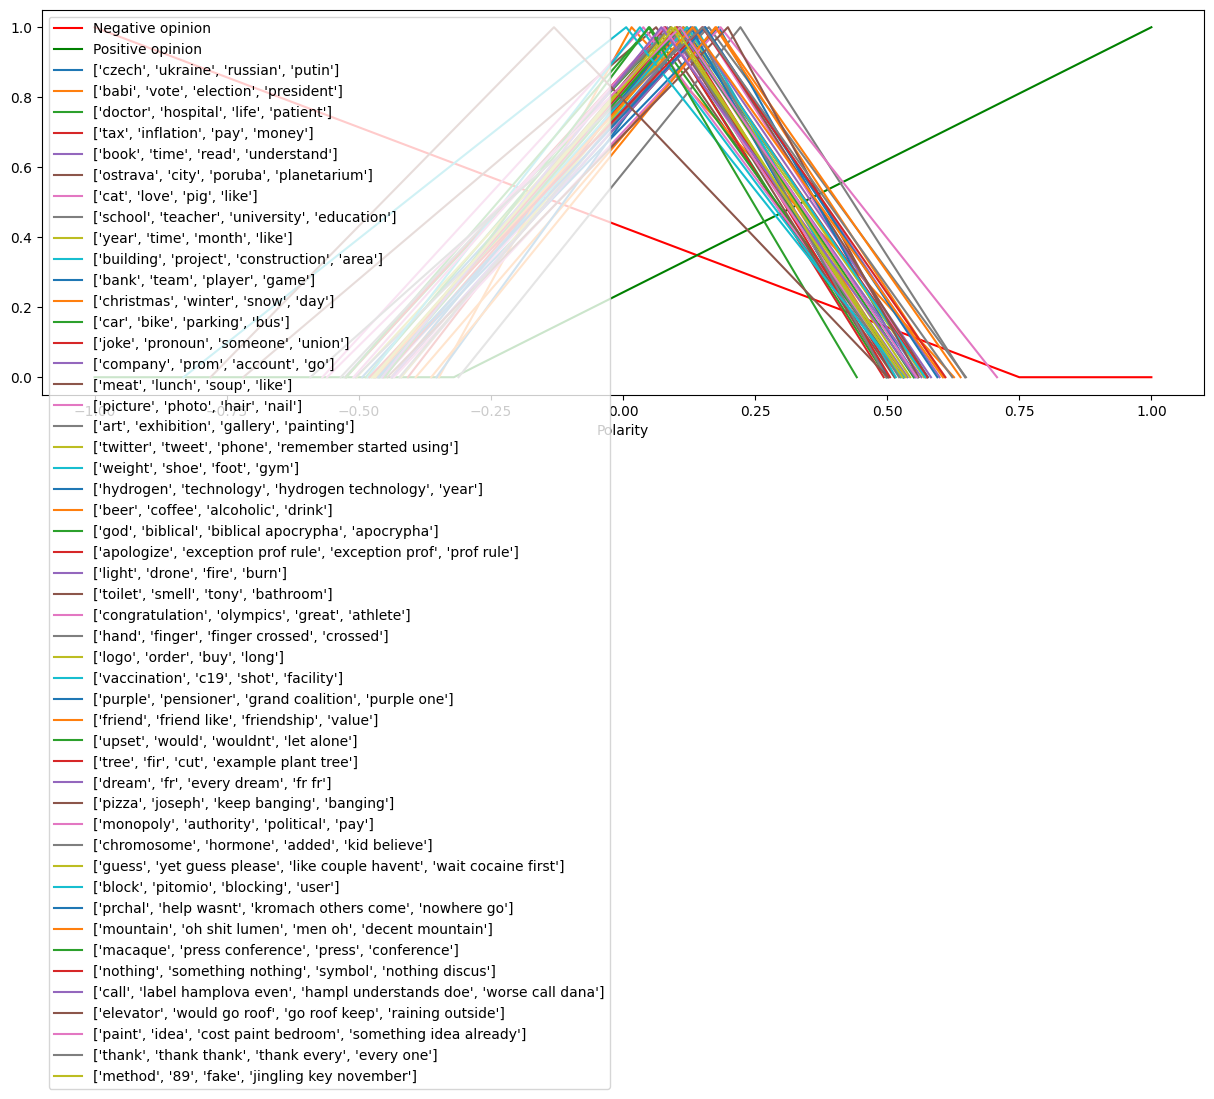

In [25]:
plt.figure(figsize=(15, 5))
plt.xlabel('Polarity')
plt.plot([-1, 0.75, 1], [1, 0, 0], color='red', label='Negative opinion')
plt.plot([-1, -0.32, 1], [0, 0, 1], color='green', label='Positive opinion')

topics_processed = []

for topic in topic_model.get_topics().items():
    if topic[0] == -1:
        continue
    #if (topic[0] - 1) % 6 != 0:
    #    continue
    core = mean_sentiments[topic[0]]
    support_left = core - semivariance_left[topic[0]] * 1.5
    support_right = core + semivariance_right[topic[0]] * 1.5
    con_pos = conformity_positive([support_left, core, support_right], -0.32, 1)
    con_neg = conformity_negative([support_left, core, support_right], 1, -0.75)
    topic_name = str([t[0] for t in topic[1][:4]])
    plt.plot([support_left, core, support_right], [0, 1, 0], label=topic_name)
    print(f'TOPIC: {topic_name}, CON.POS.: {con_pos:.2f}, CON.NEG.: {con_neg:.2f}')

    topics_processed.append({
        'name': topic_name,
        'sent_mean': core,
        'sent_mean_discrete': mean_sentiments_discrete[topic[0]],
        'support_left': support_left,
        'support_right': support_right,
        'con_pos': con_pos,
        'con_neg': con_neg,
        'controversy': support_right - support_left,
        'controversy_discrete': diversity_discrete[topic[0]],
        'mass': topic_reprs[topic[0]],
        'entropy': entropy[topic[0]]
    })

topics_processed = pd.DataFrame(topics_processed)

plt.legend()
plt.show()


### Exploration of topics

In [26]:
con_min = min(topics_processed.con_pos.min(), topics_processed.con_neg.min())
con_max = max(topics_processed.con_pos.max(), topics_processed.con_neg.max())
topics_processed['con_pos'] = (topics_processed.con_pos - con_min) / (con_max - con_min)
topics_processed['con_neg'] = (topics_processed.con_neg - con_min) / (con_max - con_min)
topics_processed

,name,sent_mean,sent_mean_discrete,support_left,support_right,con_pos,con_neg,controversy,controversy_discrete,mass,entropy
0,"['czech', 'ukraine', 'russian', 'putin']",0.114677,0.347359,-0.493625,0.576873,0.379725,0.490859,1.070498,0.879342,825.734037,0.911123
1,"['babi', 'vote', 'election', 'president']",0.113783,0.366262,-0.438540,0.532701,0.320338,0.439652,0.971241,0.865852,791.127474,0.900944
2,"['doctor', 'hospital', 'life', 'patient']",0.079374,0.280335,-0.486687,0.498801,0.229799,0.521399,0.985488,0.921412,439.059011,0.942544
3,"['tax', 'inflation', 'pay', 'money']",0.103977,0.384266,-0.407009,0.514643,0.283001,0.418865,0.921652,0.852340,457.750070,0.890696
4,"['book', 'time', 'read', 'understand']",0.083403,0.286957,-0.526689,0.538830,0.289756,0.553623,1.065519,0.917656,387.294894,0.939758
5,"['ostrava', 'city', 'poruba', 'planetarium']",0.062708,0.317109,-0.718680,0.513883,0.230156,0.734579,1.232563,0.899442,280.880532,0.926195
6,"['cat', 'love', 'pig', 'like']",0.151717,0.435020,-0.453641,0.573711,0.424913,0.415613,1.027352,0.810757,267.364693,0.858821
7,"['school', 'teacher', 'university', 'education']",0.222323,0.589684,-0.311273,0.647486,0.615571,0.202162,0.958759,0.652272,155.202390,0.732124
8,"['year', 'time', 'month', 'like']",0.107858,0.341473,-0.504270,0.573319,0.366301,0.507703,1.077588,0.883396,165.085038,0.914172
9,"['building', 'project', 'construction', 'area']",0.137626,0.519321,-0.455701,0.516344,0.329448,0.431767,0.972045,0.730306,139.071231,0.795605


In [27]:
print(topics_processed[['sent_mean', 'sent_mean_discrete']].corr())
print(topics_processed[['sent_mean', 'sent_mean_discrete', 'controversy', 'controversy_discrete', 'entropy']].corr())

                    sent_mean  sent_mean_discrete
sent_mean            1.000000            0.849948
sent_mean_discrete   0.849948            1.000000
                      sent_mean  sent_mean_discrete  controversy  \
sent_mean              1.000000            0.849948    -0.346964   
sent_mean_discrete     0.849948            1.000000    -0.190091   
controversy           -0.346964           -0.190091     1.000000   
controversy_discrete  -0.807788           -0.849100     0.244148   
entropy               -0.801850           -0.844437     0.245239   

                      controversy_discrete   entropy  
sent_mean                        -0.807788 -0.801850  
sent_mean_discrete               -0.849100 -0.844437  
controversy                       0.244148  0.245239  
controversy_discrete              1.000000  0.999783  
entropy                           0.999783  1.000000  


# Data export

We want to export topic data for dashboard visualization. This visualization also requires a short summary of positive and negative aspects of each topic. For these purposes we export several positive and negative tweets for each topic

In [16]:
MIN_PROBA = 0.10

orig_text_series = pd.Series(texts_orig)
sentiment_series = pd.Series(sentiments[:, 0])

def topic_posts(sentiment, topic_id):
    topic_name = topics_processed['name'].loc[topic_id]
    topic_selector = topic_model.probabilities_[:, topic_id] > MIN_PROBA
    topic_sentiments = sentiment_series[topic_selector]
    sent_median = topic_sentiments.median()
    topic_posts = orig_text_series[topic_selector]
    sentiment_selector = topic_sentiments > sent_median if sentiment == 'positive' else topic_sentiments < sent_median
    topic_posts = topic_posts[sentiment_selector][:60]
    return [t.strip() for t in topic_posts.tolist()]

topic_posts = [{'positive': topic_posts('positive', t), 'negative': topic_posts('negative', t)} for t in range(0, 49)]
with open('../datasets/topics_tweets.json', 'w') as tweets_fd:
    json.dump(topic_posts, tweets_fd)

We now use the function to actually summarize positive and negative aspects of each topic.

In [28]:
topics_processed.to_csv('../datasets/topics_processed_linear.csv', index=False)